In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import sys
import pandas as pd

from astropy.coordinates import SkyCoord
from datetime import datetime


In [3]:
sys.path.insert(0, '/arc/home/mseth/beam-model')
from beam_model import composite as cmp
from beam_model import utils
from beam_model.bm_data.get_data import main
from beam_model import config

import site
site.addsitedir('/arc/home/mseth/.local/lib/python3.8/site-packages')
import astrodendro

sys.path.insert(0, '/arc/home/mseth/frb-calibration-master')
import frb_calibration.calibration_scheduler_helpers as cal_scheduler
import frb_calibration.intensity_calibration_helpers as ich

In [4]:
%matplotlib inline

 Load in data

In [5]:
main()

Fetching: primary_power_beam.npz
Fetching: beam_XX_v1.h5
Fetching: beam_YY_v1.h5
Fetching: beam_v1_SVD_diff_XX.h5
Fetching: beam_v1_SVD_diff_YY.h5
Fetching: beam_v1_SVD_YY.h5
Fetching: beam_v1_SVD_XX.h5
Download Complete


In [6]:
data = np.load('/arc/projects/chime_frb/mseth/cyg_A/frb_CYG_A_2025-07-03_beam_1105.npz', allow_pickle=True) 

In [7]:
spectra = data['spectra']
median_timeseries = data['median_timeseries']
ts = np.mean(spectra, axis=0)

In [8]:
# Find index of where average timeseries peaks  
peak_idx = np.argmax(ts)

# Get the spectra for that time
spectra_at_peak = spectra[:,peak_idx]
spectra_at_peak[spectra_at_peak==0]=np.nan

In [9]:
peak_idx

1769

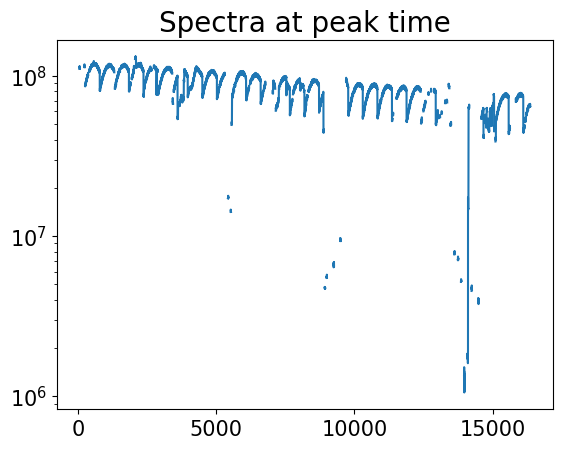

In [10]:
plt.figure()
plt.plot(spectra_at_peak)
plt.yscale('log')
plt.title("Spectra at peak time")
plt.show()

Get sensitivities

In [11]:
source_name = "CYG_A"
coords = SkyCoord.from_name(source_name)

source_ra = coords.ra.deg
source_dec = coords.dec.deg

In [16]:
cbm = cmp.CompositeBeamModel(config.current_config, interpolate_bad_freq=True)


In [26]:
time, beam = ich.get_calibrator_transit(source_ra, source_dec, "20250703")
#convert time to datetime
start_date = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f UTC+0000')- pd.Timedelta(minutes=10)
date_time_arr = [start_date + pd.Timedelta(seconds=i) for i in range(1200)]
x_arr = []
y_arr = []
sensitivity_arr = []
for date_time in date_time_arr:
    x, y = cbm.get_position_from_equatorial(source_ra, source_dec, date_time)
    x_arr.append(x)
    y_arr.append(y)

x_arr = np.array(x_arr)
y_arr = np.array(y_arr)

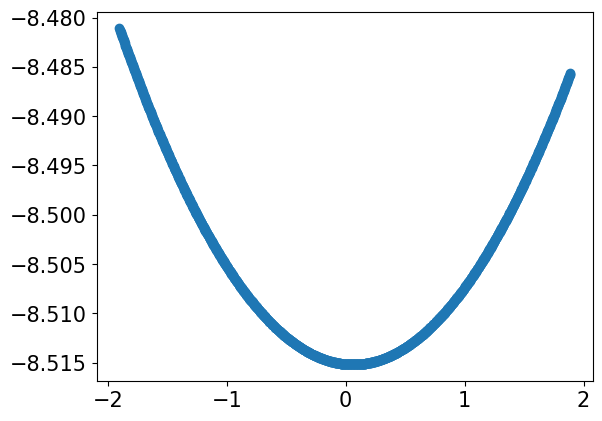

In [27]:
plt.figure()
plt.scatter(x_arr, y_arr)
plt.show()

In [19]:
# Finding which beams are transited and what times 

time = datetime(2025, 7, 3)

transited_beam_ids = cal_scheduler.calculate_transit_beams_precise(
    source_ra, source_dec)

transit_times = cal_scheduler.calculate_next_transit_times_precise(
    source_ra, source_dec, time, transited_beam_ids)

print("Precise beams transited: {}".format(sorted(transited_beam_ids)))
print("Precise transit times: {}".format(transit_times))

Precise beams transited: [105, 106, 1105, 1106, 2105, 2106, 3105, 3106]
Precise transit times: [datetime.datetime(2025, 7, 3, 9, 10, 10, 327550), datetime.datetime(2025, 7, 3, 9, 10, 9, 319147), datetime.datetime(2025, 7, 3, 9, 12, 17, 469765), datetime.datetime(2025, 7, 3, 9, 12, 16, 461361), datetime.datetime(2025, 7, 3, 9, 14, 23, 603577), datetime.datetime(2025, 7, 3, 9, 14, 24, 611980), datetime.datetime(2025, 7, 3, 9, 16, 29, 737388), datetime.datetime(2025, 7, 3, 9, 16, 31, 754195)]


In [20]:
# Pick out the time it transits our beam 
transit_time = transit_times[2]

In [21]:
# Make an array of times and positions
start_time = transit_time - pd.Timedelta(minutes=10)
end_time = transit_time + pd.Timedelta(minutes=10)

datetime_arr = pd.date_range(start=start_time, end=end_time, freq='S')

pos_list = []
for i in datetime_arr:
    pos = cbm.get_position_from_equatorial(source_ra, source_dec, i)
    pos_list.append(pos)

pos_array = np.array(pos_list)

In [23]:
pos_array[1]

array([-1.89272212, -8.48145465])

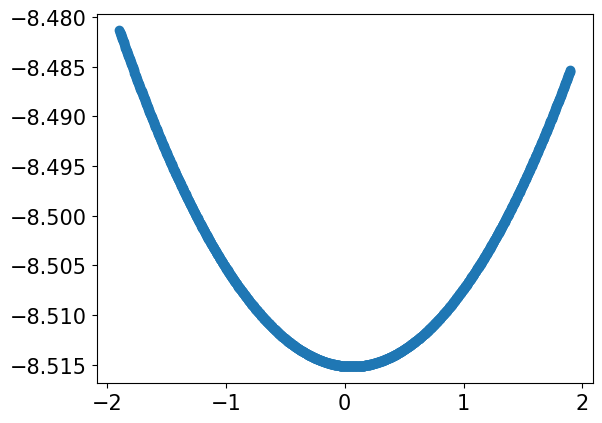

In [24]:
plt.figure()
plt.scatter(pos_array[:,0], pos_array[:,1])
plt.show()

In [29]:
#Calculate sensitivity 
freqs = np.linspace(400, 800, 16384)

sensitivity = cbm.get_sensitivity(1105, pos_array, freqs)
sensitivity = np.squeeze(sensitivity)

#Find index of where mean sensitivity is maximum 
max_sens_idx = np.argmax(np.mean(sensitivity, axis=1))

#Get sensitivity spectrum at max index 
sensitivity_at_peak = np.squeeze(sensitivity[max_sens_idx,:])


In [44]:
sens_a = cbm.get_sensitivity(1105, np.array([x_arr, y_arr]).T, freqs).squeeze()

max_sensa = np.argmax(np.mean(sens_a, axis=1))
sens_peak = sensitivity[max_sensa,:].squeeze()

In [34]:
len(sensitivity_at_peak)

16384

In [46]:
len(sens_peak)

16384

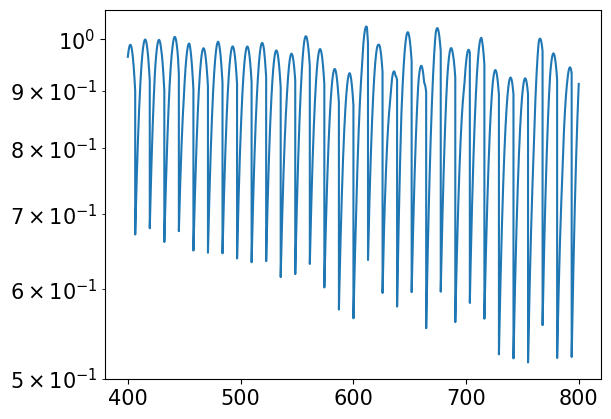

In [68]:
plt.figure()
plt.plot(freqs, sens_peak)
plt.yscale('log')
plt.show()

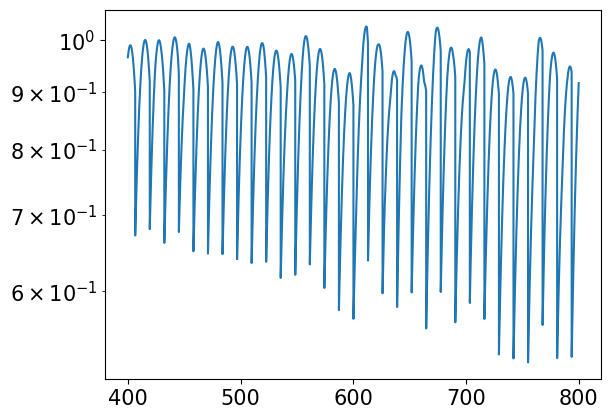

In [69]:
plt.figure()
plt.plot(freqs, sensitivity_at_peak)
plt.yscale('log')
plt.show()

In [70]:
corrected_two = spectra_at_peak / sens_peak

Correcting

In [71]:
corrected_spectra = spectra_at_peak / sensitivity_at_peak

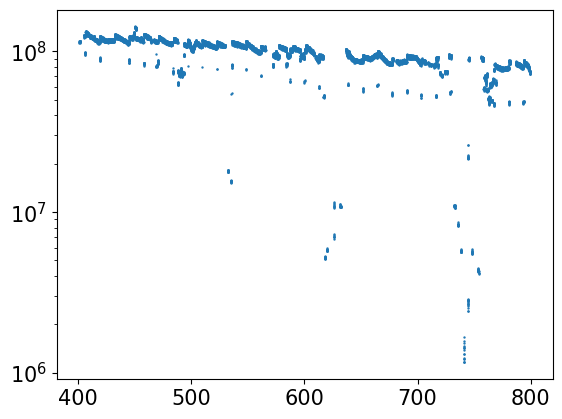

In [72]:
plt.figure()
plt.scatter(freqs, corrected_spectra, s=0.5)
plt.yscale('log')
plt.show()

In [79]:
# Define conversion equation

def bf_to_jy(bf_int, f_good):
    factor = (np.square(1024) * 128) / (np.square(4) * 0.806745 * 400)
    result = bf_int / ( factor * np.square(f_good) ) 
    return result

jansky_spectra = bf_to_jy(corrected_spectra, 0.8)

In [80]:
js_sp = bf_to_jy(corrected_two, 0.8)

In [81]:
# Make a function for the spectrum (from Perley & Butler 2016)

def spectrum(a_0, a_1, a_2, a_3, a_4, GHz):
    exponent = a_0 + (a_1 * np.log10(GHz)) + (a_2 * np.square(np.log10(GHz))) + (a_3 * np.power(np.log10(GHz),3)) +(a_4* np.power(np.log10(GHz),4))
    result = np.power(10, exponent)
    return result 

cygA_spectrum = spectrum(a_0 = 3.34598,
                         a_1 = -1.0022,
                         a_2 = -0.225,
                         a_3 = 0.023,
                         a_4= 0.043,
                         GHz = freqs/1000)

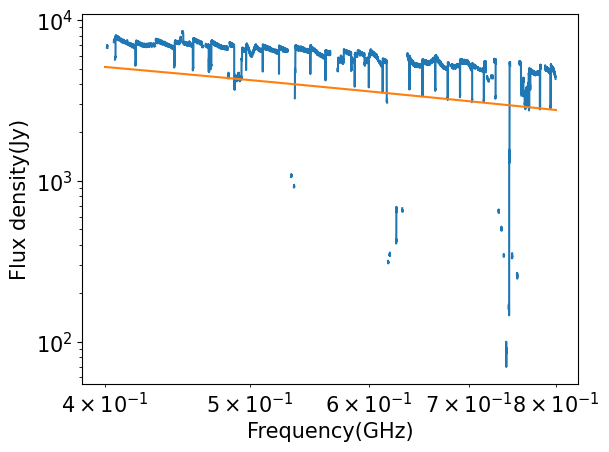

In [82]:
# Plot corrected spectrum vs. modeled spectrum 
plt.figure()
plt.plot(freqs/1000, jansky_spectra, label="Corrected Spectrum at Peak")
plt.plot(freqs/1000, cygA_spectrum, label='Model Spectrum')
plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Frequency(GHz)')
plt.ylabel('Flux density(Jy)')
plt.show()

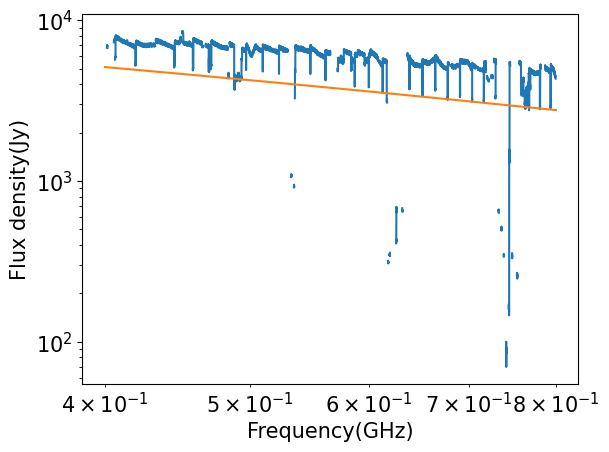

In [83]:
# Plot corrected spectrum vs. modeled spectrum 
plt.figure()
plt.plot(freqs/1000, js_sp, label="Corrected Spectrum at Peak")
plt.plot(freqs/1000, cygA_spectrum, label='Model Spectrum')
plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Frequency(GHz)')
plt.ylabel('Flux density(Jy)')
plt.show()

In [78]:
len(jansky_spectra)

16384